In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from maystats import *
import itertools

In [41]:
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='5.00', start_index=0, end_index=1000 )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='2.00')
# construct interpolator for PS
mean_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0


nr 9999 nb 250 bin 0.9748949789957991 sky 0.001225


In [42]:
mean_interp_ps.P( params.T[0] * 1.001 ) 

0.5653907970594844

In [141]:
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='2.00')

# construct ten interps from different realizations
interp_list = []
for i in range(5):
    ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='5.00', start_index=i*2000, end_index=(i+1)*2000 )
    params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

    # remove the 0th row (fiducial A)
    ps_mean = np.delete(ps_mean, 0, axis=0)
    params = np.delete(params, 0, axis=1)
    # construct interpolator for PS
    mean_interp_ps = Interp(obsarr=ps_mean.copy(),
                            cosmo_params=params,
                            invcov=invcov,
                            fiducial_model=ps_mean[0].copy()) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

    interp_list.append(mean_interp_ps)
    print( interp_list[-1].P( params.T[0] * 1.001 )  )
    
# USE WILL METHOD
def combine_P(parameter_input):
    
    num_pairs = 0
    total_sum = 0.0
    
    
    for interp_a, interp_b in itertools.combinations( interp_list, r=2):
        num_pairs += 1
        dm_a = interp_a.fid - interp_a.interp_func( parameter_input ) # d - mu
        dm_b = interp_b.fid - interp_b.interp_func( parameter_input ) # d - mu
        term = ( -0.5 * np.dot(dm_a.T,np.dot(invcov,dm_b))  )
       
        
        total_sum += term
        print(term)
    return np.exp( total_sum / num_pairs )


nr 9999 nb 250 bin 0.9748949789957991 sky 0.001225
0.622972798364454
0.6579135215241353
0.5904611240857741
0.6701953488963155
0.5942909018335228


In [148]:
combine_P( [0.1, 0.3, 0.83] )

-0.05371877943328442
-0.05370994085394974
-0.04930727743749682
-0.052726317247747664
-0.052195552212231246
-0.05247519486280448
-0.0531537525118171
-0.05176582308606756
-0.05421602362260626
-0.057827575355475544


0.9482760532903299

In [147]:
combine_P( [0.06, 0.3, 0.83] )

11.164133379117038
-19.62214206373796
9.084733037262122
10.825774984245951
14.618995608364452
-27.962272444237914
8.53641683115434
15.836638266205657
24.92861024767041
28.06025377562657


1895.2654031964855

In [109]:
interp_list[0].P( [0.14, 0.3, 0.83] )

3.470155444328724e-32

In [108]:
mean_interp_ps.P( [0.14, 0.3, 0.83] )

2.7281452760304093e-34

In [69]:

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map( combine_P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_s5_combine.npy', cube)
np.save( 'cubes/5z_PC_s5_combine_xyz.npy', np.array([x,y,z]) )

(0.28, 0.32)

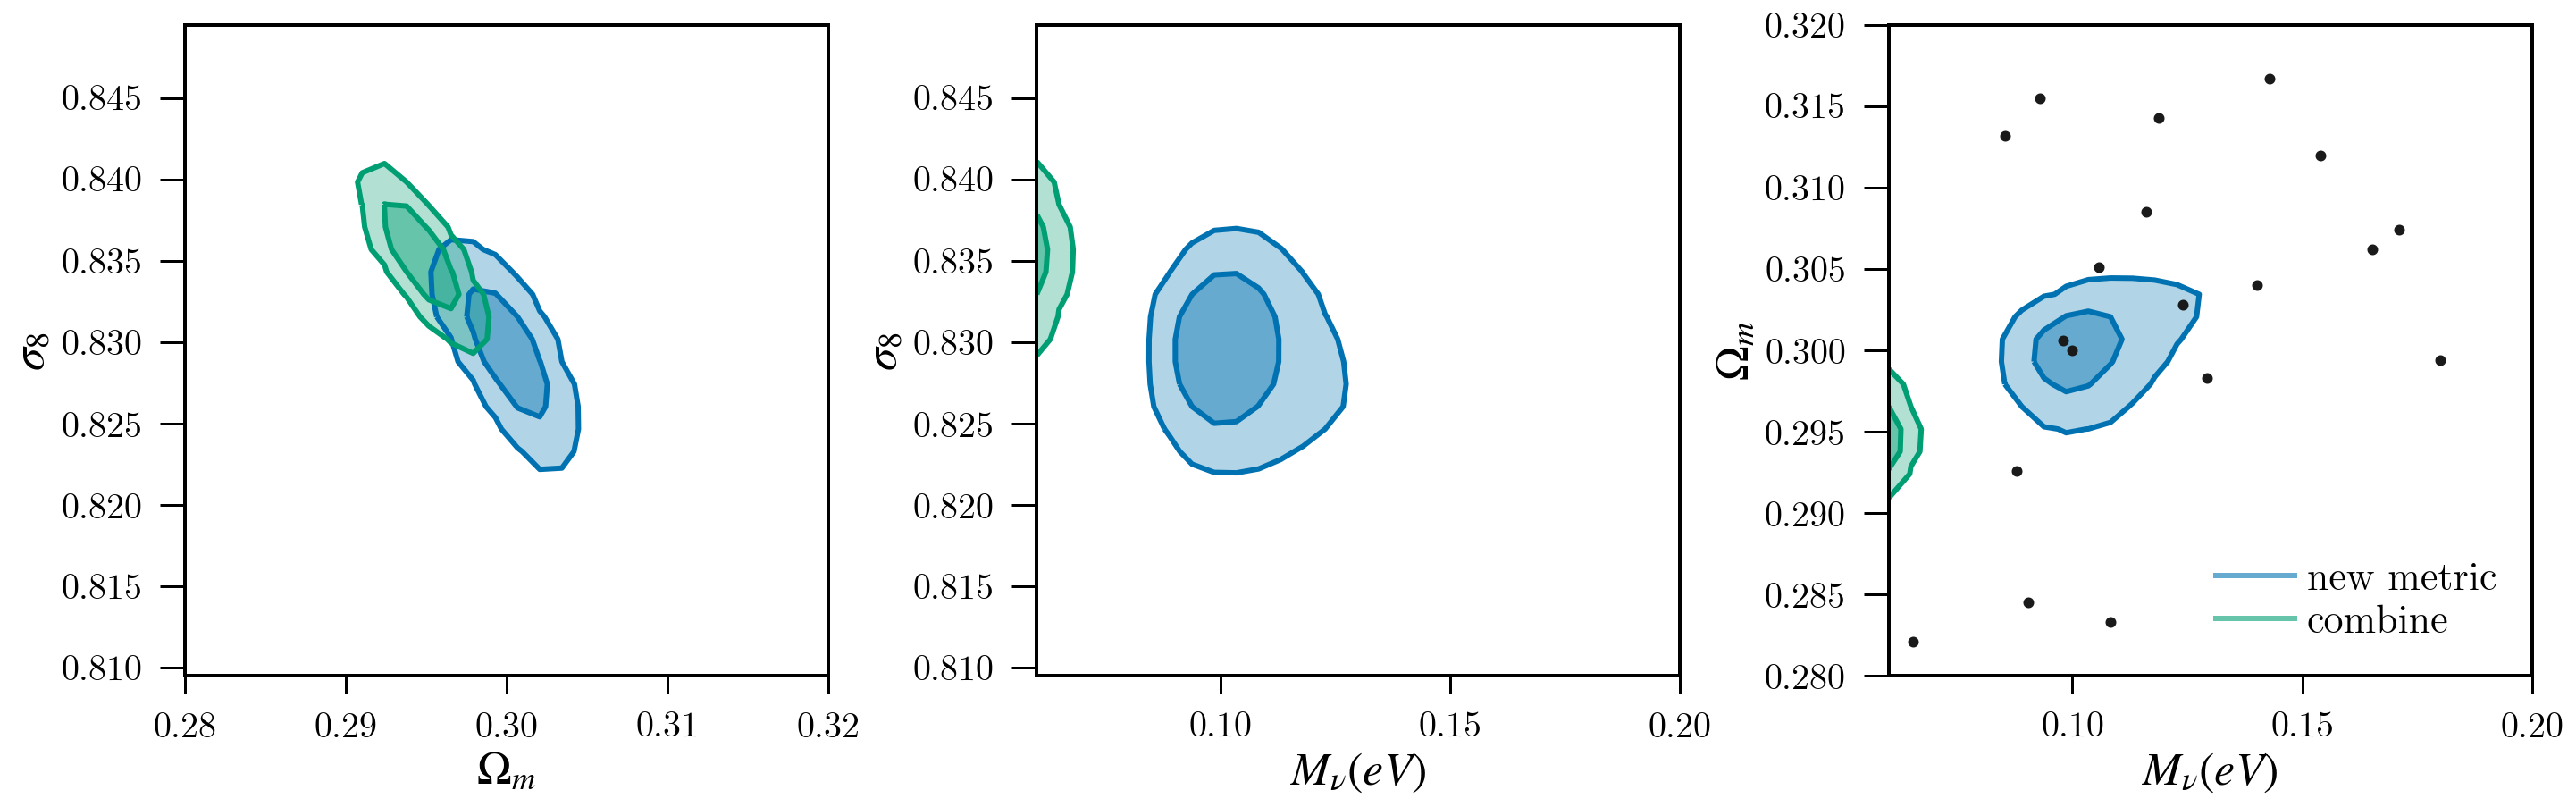

In [151]:
import plot_utils
params_table = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PC_s5_xyz_metric.npy' )
c2 = np.load( 'cubes/5z_PC_s5_metric.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='new metric')

x,y,z = np.load(  'cubes/5z_PC_s5_xyz_metric.npy' )
c2 = np.load( 'cubes/5z_PC_s5_metric_combine.npy' )

fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[2],
                       input_label='combine')


fig.tight_layout()

plt.legend()

axes[-1].scatter( params[0,:], params[1,:] )
axes[-1].set_xlim(0.06, 0.2)
axes[-1].set_ylim(0.28,0.32)